## No usar este método, es mejor recortar los randoms de todo el cielo

### Traer códigos de Filbao para generar randoms con healpix

In [19]:
def generate_random_radec(ra,dec,nside,nrand):

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = int(10e6)  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    u = np.random.uniform(-1, 1, num_randoms)
    dec_random_rad = np.arcsin(u)
    dec_random = np.rad2deg(dec_random_rad)
    #dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices]
    dec_random = dec_random[valid_indices]
    
    if len(ra_random) < nrand:
        raise ValueError(f"Not enough random points generated: {len(ra_random)} < {nrand}")

    return ra_random[:nrand], dec_random[:nrand]

import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from astropy.io import ascii
import treecorr
import matplotlib.pyplot as plt

# Read UHECR data
events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
events_a8 = events_a8[mask_eve]#[:10000]

# Read galaxy data
gxs = ascii.read('../data/VLS_ang5_cz_700control_def.txt')
gxs = gxs[gxs['cz'] > 1000.]
data = gxs

nmult = 10

# Calculations
ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], ra_units='deg', dec_units='deg')
#seeds = np.linspace(1000,1+params['nquant']-1,params['nquant'],dtype=int)

# Generate ra_rand and dec_rand for rcat
ra_rand, dec_rand = generate_random_radec(data['_RAJ2000'], data['_DEJ2000'], 32, nmult*len(data))

# Correctly create the random catalog
rcat = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='deg', dec_units='deg')

print(len(data),len(ra_rand),len(events_a8))

1400 14000 29481


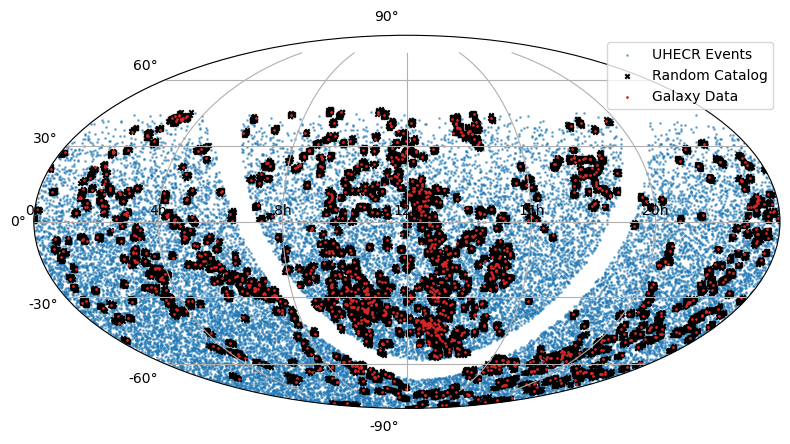

In [20]:

# Create figure with three Mollweide subplots
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'mollweide'}, figsize=(8, 6))

def format_axes(ax):
    """Format axes with RA in hours and Dec in degrees."""
    # RA ticks every 60 degrees (converted to hours)
    xticks_deg = np.arange(0, 360, 60)
    xticks_rad = np.radians(xticks_deg) - np.pi  # Shift RA to center at 180 degrees
    xtick_labels = [f'{int(deg/15)}h' for deg in xticks_deg]
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels(xtick_labels)
    
    # Dec ticks every 30 degrees
    yticks_deg = np.arange(-90, 91, 30)
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f'{deg}°' for deg in yticks_deg])
    ax.grid(True)


# Plot UHECR Events (ecat)
ra_ecat = events_a8['RA']
dec_ecat = events_a8['dec']
ra_rad_ecat = np.radians(ra_ecat) - np.pi
dec_rad_ecat = np.radians(dec_ecat)
ax.scatter(ra_rad_ecat, dec_rad_ecat, s=1, color='C00', alpha=0.5, label='UHECR Events')
#ax.set_title('UHECR Events (ecat)', pad=20)
#format_axes(axes[1])

# Plot Random Catalog (rcat)
ra_rcat = ra_rand
dec_rcat = dec_rand
ra_rad_rcat = np.radians(ra_rcat) - np.pi
dec_rad_rcat = np.radians(dec_rcat)
ax.scatter(ra_rad_rcat, dec_rad_rcat, s=10, marker='x', color='k', alpha=1, label='Random Catalog')
#ax.set_title('Random Catalog (rcat)', pad=20)

# Plot Galaxy Data
ra_data = data['_RAJ2000']
dec_data = data['_DEJ2000']
ra_rad_data = np.radians(ra_data) - np.pi
dec_rad_data = np.radians(dec_data)
ax.scatter(ra_rad_data, dec_rad_data, s=1, color='C03', alpha=1, label='Galaxy Data')
#ax.set_title('Galaxy Data', pad=20)

plt.legend(loc='upper right', fontsize=10)
format_axes(ax)
plt.tight_layout()
plt.show()


In [ ]:

xi_bs, varxi_bs = [], []
for q in range(params['nquant']):
    print(f'{q + 1}/{params["nquant"]}')
    results = get_xibs(data[q], params['nbootstrap'], params['nbins'], rcat[q], ecat, treecorr_config)
    xi_bs.append(results[0])
    varxi_bs.append(results[1])
th = results[2]